Датасет [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data) містить 2 категорії зображень МРТ головного мозку: з пухлинами та без.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Завантаження + базові трансформації**

Тут:

- Підключаю Google Drive.

- Задаю шлях до каталогу brain_tumor, у якому є дві папки: yes (з пухлиною), no (без).

- Створюю базову трансформацію (лише Resize + ToTensor).

- Завантажую дані через ImageFolder і формую DataLoader.

- Вивід 6 "сирих" зображень з мітками.

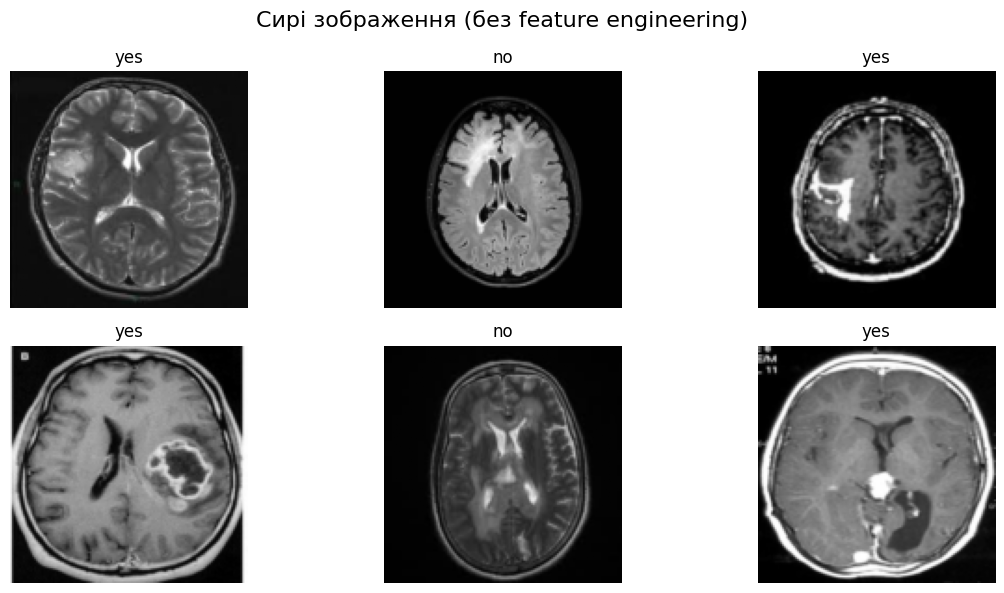

In [22]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/brain_tumor'

base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(root=data_dir, transform=base_transform)
base_loader = DataLoader(base_dataset, batch_size=6, shuffle=True)

class_names = base_dataset.classes

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

images, labels = next(iter(base_loader))
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], class_names[labels[i]])
plt.suptitle("Сирі зображення (без feature engineering)", fontsize=16)
plt.tight_layout()
plt.show()

**2. Побудова базової CNN**

Створюється невелика згорткова мережа, що буде базовою архітектурою.

Мержа складатиметься з кількох Conv2d, ReLU, MaxPool, Flatten, Linear.

Вихідний шар видає 2 класи: yes (пухлина), no (норма).

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

**3. Навчання CNN на необроблених даних**

Задаємо функцію втрат та оптимізатор.

Ділимо датасет на train/test.

Навчаємо модель протягом 5 епох з learning rte = 0.01.

Виводимо: loss по епохах, accuracy по train.

Отримуємо базовий рівень, від якого будемо відштовхуватися.

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_size = int(0.8 * len(base_dataset))
test_size = len(base_dataset) - train_size
train_dataset, test_dataset = random_split(base_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 5
base_losses = []
base_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    base_losses.append(epoch_loss)
    base_accuracies.append(epoch_acc)

    print(f"[Base] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

[Base] Epoch 1/5, Loss: 0.7979, Accuracy: 50.50%
[Base] Epoch 2/5, Loss: 0.5933, Accuracy: 71.78%
[Base] Epoch 3/5, Loss: 0.5218, Accuracy: 75.74%
[Base] Epoch 4/5, Loss: 0.5188, Accuracy: 74.75%
[Base] Epoch 5/5, Loss: 0.4847, Accuracy: 79.21%


**4. Оцінка бзової моделі на тестових даних**

In [25]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc_base = 100 * correct / total
print(f"Test Accuracy before feature engineering: {test_acc_base:.2f}%")

Test Accuracy before feature engineering: 66.67%


**5. Feature Engineering

Додамо трансформації, які виконують класичний feature engineering для зображень:

- симетричне збагачення RandomHorizontalFlip(),

- випадковий повріт у межах від -5 до +5 градусів + зсув по ширині та висоті RandomAffine,

- варіація контрасту/яскравості ColorJitter(),

- стандартизація пікселів Normalize().

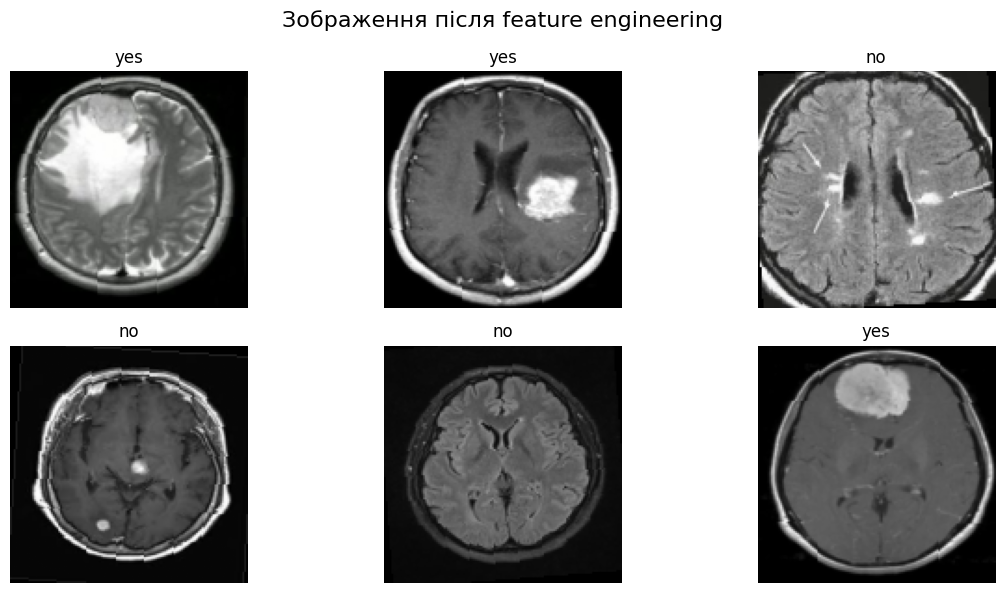

In [26]:
aug_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

aug_dataset = datasets.ImageFolder(root=data_dir, transform=aug_transform)
aug_loader = DataLoader(aug_dataset, batch_size=6, shuffle=True)

images_aug, labels_aug = next(iter(aug_loader))

def imshow_normalized(img, title):
    img = img * 0.5 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow_normalized(images_aug[i], class_names[labels_aug[i]])
plt.suptitle("Зображення після feature engineering", fontsize=16)
plt.tight_layout()
plt.show()

**6. Навчання CNN на зображеннях після feature engineering**

Використовуємо ту саму архітектуру SimpleCNN

Переініціалізуємо нову модель

Навчаємо 5 епох, збираємо loss по епохах, accuracy по train

Потім -- порівняння з попередньою моделлю

In [27]:
model_fe = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fe.parameters(), lr=0.001)

train_size = int(0.8 * len(aug_dataset))
test_size = len(aug_dataset) - train_size
train_dataset_fe, test_dataset_fe = random_split(aug_dataset, [train_size, test_size])

train_loader_fe = DataLoader(train_dataset_fe, batch_size=32, shuffle=True)
test_loader_fe = DataLoader(test_dataset_fe, batch_size=32, shuffle=False)

fe_losses = []
fe_accuracies = []

for epoch in range(num_epochs):
    model_fe.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_fe:
        images, labels = images.to(device), labels.to(device)
        outputs = model_fe(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader_fe.dataset)
    epoch_acc = 100 * correct / total
    fe_losses.append(epoch_loss)
    fe_accuracies.append(epoch_acc)

    print(f"[Feature Engineering] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

[Feature Engineering] Epoch 1/5, Loss: 0.7949, Accuracy: 46.04%
[Feature Engineering] Epoch 2/5, Loss: 0.6159, Accuracy: 66.83%
[Feature Engineering] Epoch 3/5, Loss: 0.5426, Accuracy: 76.24%
[Feature Engineering] Epoch 4/5, Loss: 0.5044, Accuracy: 79.21%
[Feature Engineering] Epoch 5/5, Loss: 0.4692, Accuracy: 79.70%


**7. Оцінка після feature engineering**

In [28]:
model_fe.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader_fe:
        images, labels = images.to(device), labels.to(device)
        outputs = model_fe(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc_fe = 100 * correct / total
print(f"Test Accuracy after feature engineering: {test_acc_fe:.2f}%")

Test Accuracy after feature engineering: 84.31%


**8. Графіки loss і accuracy**

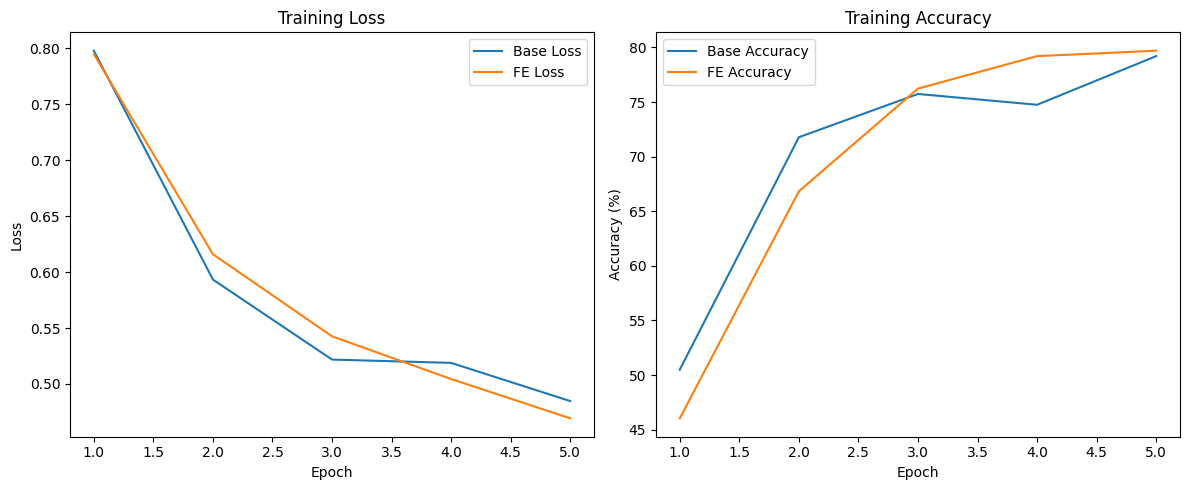

In [29]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, base_losses, label='Base Loss')
plt.plot(epochs, fe_losses, label='FE Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, base_accuracies, label='Base Accuracy')
plt.plot(epochs, fe_accuracies, label='FE Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**9. Короткий пілсумок**

Суть роботи була у дослідженні впливу feature engineering на якість навчання нейронної мережі. Для цього реалізовано два варіанти.

Базовий варіант — навчання моделі на зображеннях без попередньої обробкию

Покращений варіант — навчання на даних після застосування трансформацій:
RandomHorizontalFlip, RandomRotation, ColorJitter, Normalize.

У ході навчання точність на тренувальному наборі в обох випадках дійшла до ~79%, однак:

- у базовому варіанті тестова точність склала 66.67%,

- після feature engineering — точність зросла до 84.31%.

Тобто для train точність майже не змінилась, але зміна вхідних ознак дала кращу генералізацію на невиданих даних.

Чому так? Напевно, через "ускладнення" тренувальних даних навчання відбувається повільніше (тобто, повільніше зростає точність). Але це не дає моделі перенавчитись, тому на тестовій вибірці (до якої не були застосовані трансформації) показує кращий результат, ніжж у базовому варіанті.